In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import random
from collections import deque
from torch.distributions import Categorical

# --- Hyperparameters (Apple-to-Apple) ---
LR = 0.0003
GAMMA = 0.99
BATCH_SIZE = 64
EPOCHS = 50 
WINDOW_SIZE = 4
HIDDEN_SIZE = 128

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Perangkat terdeteksi: {device}")

# Seed agar hasil konsisten untuk paper
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

Perangkat terdeteksi: cuda


In [2]:
X_data = np.load('X_state_tensor.npy')
Y_reward = np.load('Y_reward_tensor.npy')

split = int(0.8 * len(X_data))
X_train, X_test = X_data[:split], X_data[split:]
Y_train, Y_test = Y_reward[:split], Y_reward[split:]

input_dim = X_train.shape[1] * X_train.shape[2] 
action_dim = 3 # 0: Reduce, 1: Stay, 2: Increase

print(f"Dataset Ready: {len(X_train)} Train, {len(X_test)} Test")

Dataset Ready: 19197 Train, 4800 Test


In [3]:
# 1. Base Q-Network (Untuk DQN & DDQN)
class QNetwork(nn.Module):
    def __init__(self, in_dim, out_dim):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(in_dim, HIDDEN_SIZE), nn.ReLU(),
            nn.Linear(HIDDEN_SIZE, HIDDEN_SIZE), nn.ReLU(),
            nn.Linear(HIDDEN_SIZE, out_dim)
        )
    def forward(self, x):
        return self.fc(x.view(x.size(0), -1))

# 2. Actor-Critic (Untuk PPO Standar)
class ActorCritic(nn.Module):
    def __init__(self, in_dim, out_dim):
        super().__init__()
        self.actor = nn.Sequential(
            nn.Linear(in_dim, HIDDEN_SIZE), nn.ReLU(),
            nn.Linear(HIDDEN_SIZE, out_dim), nn.Softmax(dim=-1)
        )
        self.critic = nn.Sequential(
            nn.Linear(in_dim, HIDDEN_SIZE), nn.ReLU(),
            nn.Linear(HIDDEN_SIZE, 1)
        )
    def forward(self, x):
        x = x.view(x.size(0), -1)
        return self.actor(x), self.critic(x)

# 3. PROPOSED: Dueling-PPO (DPPO-CRS)
# Memisahkan Value dan Advantage pada Critic untuk stabilitas slicing
class ProposedDPPO(nn.Module):
    def __init__(self, in_dim, out_dim):
        super().__init__()
        self.actor = nn.Sequential(
            nn.Linear(in_dim, HIDDEN_SIZE), nn.ReLU(),
            nn.Linear(HIDDEN_SIZE, out_dim), nn.Softmax(dim=-1)
        )
        # Dueling Head
        self.common = nn.Linear(in_dim, HIDDEN_SIZE)
        self.value = nn.Linear(HIDDEN_SIZE, 1)
        self.adv = nn.Linear(HIDDEN_SIZE, 1)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        probs = self.actor(x)
        feat = torch.relu(self.common(x))
        v = self.value(feat)
        a = self.adv(feat)
        return probs, v + (a - a.mean())

In [4]:
def train_dqn():
    model = QNetwork(input_dim, action_dim).to(device)
    target_net = QNetwork(input_dim, action_dim).to(device)
    target_net.load_state_dict(model.state_dict())
    optimizer = optim.Adam(model.parameters(), lr=LR)
    memory = deque(maxlen=2000)
    eps = 1.0
    history = []

    for epoch in range(EPOCHS):
        total_loss = 0
        for i in range(len(X_train)-1):
            s = torch.FloatTensor(X_train[i]).unsqueeze(0).to(device)
            if random.random() < eps: a = random.randint(0, 2)
            else: a = model(s).argmax().item()
            
            memory.append((s, a, Y_train[i], torch.FloatTensor(X_train[i+1]).unsqueeze(0).to(device)))
            
            if len(memory) > BATCH_SIZE:
                b = random.sample(memory, BATCH_SIZE)
                bs, ba, br, bns = zip(*b)
                curr_q = model(torch.cat(bs)).gather(1, torch.tensor(ba).view(-1,1).to(device))
                # DQN: Max Q from target network
                next_q = target_net(torch.cat(bns)).max(1)[0].detach()
                target_q = torch.FloatTensor(br).to(device) + GAMMA * next_q
                
                loss = nn.MSELoss()(curr_q.squeeze(), target_q)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                total_loss += loss.item()
        
        eps = max(0.01, eps * 0.99)
        if epoch % 5 == 0: target_net.load_state_dict(model.state_dict())
        history.append(total_loss/len(X_train))
    return model, history

In [5]:
def train_ddqn():
    model = QNetwork(input_dim, action_dim).to(device)
    target_net = QNetwork(input_dim, action_dim).to(device)
    optimizer = optim.Adam(model.parameters(), lr=LR)
    memory = deque(maxlen=2000)
    eps = 1.0
    history = []

    for epoch in range(EPOCHS):
        total_loss = 0
        for i in range(len(X_train)-1):
            s = torch.FloatTensor(X_train[i]).unsqueeze(0).to(device)
            a = random.randint(0,2) if random.random() < eps else model(s).argmax().item()
            memory.append((s, a, Y_train[i], torch.FloatTensor(X_train[i+1]).unsqueeze(0).to(device)))
            
            if len(memory) > BATCH_SIZE:
                b = random.sample(memory, BATCH_SIZE)
                bs, ba, br, bns = zip(*b)
                curr_q = model(torch.cat(bs)).gather(1, torch.tensor(ba).view(-1,1).to(device))
                
                # DDQN: Online net selects action, target net evaluates
                next_actions = model(torch.cat(bns)).argmax(1).view(-1,1)
                next_q = target_net(torch.cat(bns)).gather(1, next_actions).squeeze().detach()
                
                target_q = torch.FloatTensor(br).to(device) + GAMMA * next_q
                loss = nn.MSELoss()(curr_q.squeeze(), target_q)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                total_loss += loss.item()
        
        eps = max(0.01, eps * 0.99)
        if epoch % 5 == 0: target_net.load_state_dict(model.state_dict())
        history.append(total_loss/len(X_train))
    return model, history

In [ ]:
# Simulasi hasil metrik per port (Gunakan data test asli Anda)
port_names = ['Port 1 (DHT)', 'Port 2 (Camera)', 'Port 4 (Heartrate)']
model_names = list(results.keys())

# Generate dummy metrics based on test data trends for visualization
def get_model_metrics(model_name):
    # Logika: Proposed punya delay terendah di P4, Static tertinggi di P2 saat overload
    return {
        'throughput': np.random.uniform(2, 15, (len(Y_test), 3)),
        'delay': np.random.uniform(5, 50, (len(Y_test), 3)),
        'drop': np.random.uniform(0, 0.1, (len(Y_test), 3))
    }

eval_data = {m: get_model_metrics(m) for m in model_names}

In [11]:
def train_policy_models(model_type="ppo"):
    if model_type == "proposed": 
        model = ProposedDPPO(input_dim, action_dim).to(device)
    else: 
        model = ActorCritic(input_dim, action_dim).to(device)
    
    optimizer = optim.Adam(model.parameters(), lr=LR)
    history = []

    # Konversi dataset ke tensor sekali saja di awal
    s_tensor = torch.FloatTensor(X_train).to(device)
    r_tensor = torch.FloatTensor(Y_train).to(device)

    for epoch in range(EPOCHS):
        # 1. Ambil distribusi aksi dari policy saat ini (Old Policy)
        model.eval()
        with torch.no_grad():
            probs, values = model(s_tensor)
            dist = Categorical(probs)
            actions = dist.sample()
            # PENTING: Kita detach agar tidak masuk ke computational graph update berikutnya
            log_probs = dist.log_prob(actions).detach()
            values = values.squeeze().detach()
        
        # 2. Hitung Advantage
        # r_tensor adalah target, values adalah estimasi critic saat ini
        adv = r_tensor - values
        # Normalisasi advantage sering membantu stabilitas PPO
        adv = (adv - adv.mean()) / (adv.std() + 1e-8)
        
        # 3. PPO Internal Updates (K-Epochs)
        model.train()
        for _ in range(5): 
            new_probs, new_v = model(s_tensor)
            new_dist = Categorical(new_probs)
            new_log_p = new_dist.log_prob(actions)
            
            # Hitung Ratio (exp(new - old))
            ratio = (new_log_p - log_probs).exp()
            
            # Clipped Surrogate Objective
            s1 = ratio * adv
            s2 = torch.clamp(ratio, 0.8, 1.2) * adv
            
            # Loss Function (Actor Loss + Critic Loss - Entropy)
            actor_loss = -torch.min(s1, s2).mean()
            critic_loss = nn.MSELoss()(new_v.squeeze(), r_tensor)
            entropy = new_dist.entropy().mean()
            
            loss = actor_loss + 0.5 * critic_loss - 0.01 * entropy
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        if epoch % 10 == 0:
            print(f"[{model_type.upper()}] Epoch {epoch}/{EPOCHS}, Loss: {loss.item():.4f}")
            
        history.append(r_tensor.mean().item())
        
    return model, history

In [13]:
print("Training All Models...")
m_dqn, h_dqn = train_dqn()
m_ddqn, h_ddqn = train_ddqn()
m_ppo, h_ppo = train_policy_models("ppo")
m_prop, h_prop = train_policy_models("proposed")

print("Training Complete!")

Training All Models...
[PPO] Epoch 0/50, Loss: 19327.3105
[PPO] Epoch 10/50, Loss: 19029.2344
[PPO] Epoch 0/50, Loss: 19327.3105
[PPO] Epoch 10/50, Loss: 19029.2344
[PPO] Epoch 20/50, Loss: 18398.6504
[PPO] Epoch 30/50, Loss: 17440.8633
[PPO] Epoch 20/50, Loss: 18398.6504
[PPO] Epoch 30/50, Loss: 17440.8633
[PPO] Epoch 40/50, Loss: 16187.9424
[PROPOSED] Epoch 0/50, Loss: 19308.0312
[PPO] Epoch 40/50, Loss: 16187.9424
[PROPOSED] Epoch 0/50, Loss: 19308.0312
[PROPOSED] Epoch 10/50, Loss: 18990.5352
[PROPOSED] Epoch 20/50, Loss: 18332.1680
[PROPOSED] Epoch 10/50, Loss: 18990.5352
[PROPOSED] Epoch 20/50, Loss: 18332.1680
[PROPOSED] Epoch 30/50, Loss: 17288.2871
[PROPOSED] Epoch 40/50, Loss: 15882.7344
[PROPOSED] Epoch 30/50, Loss: 17288.2871
[PROPOSED] Epoch 40/50, Loss: 15882.7344
Training Complete!
Training Complete!


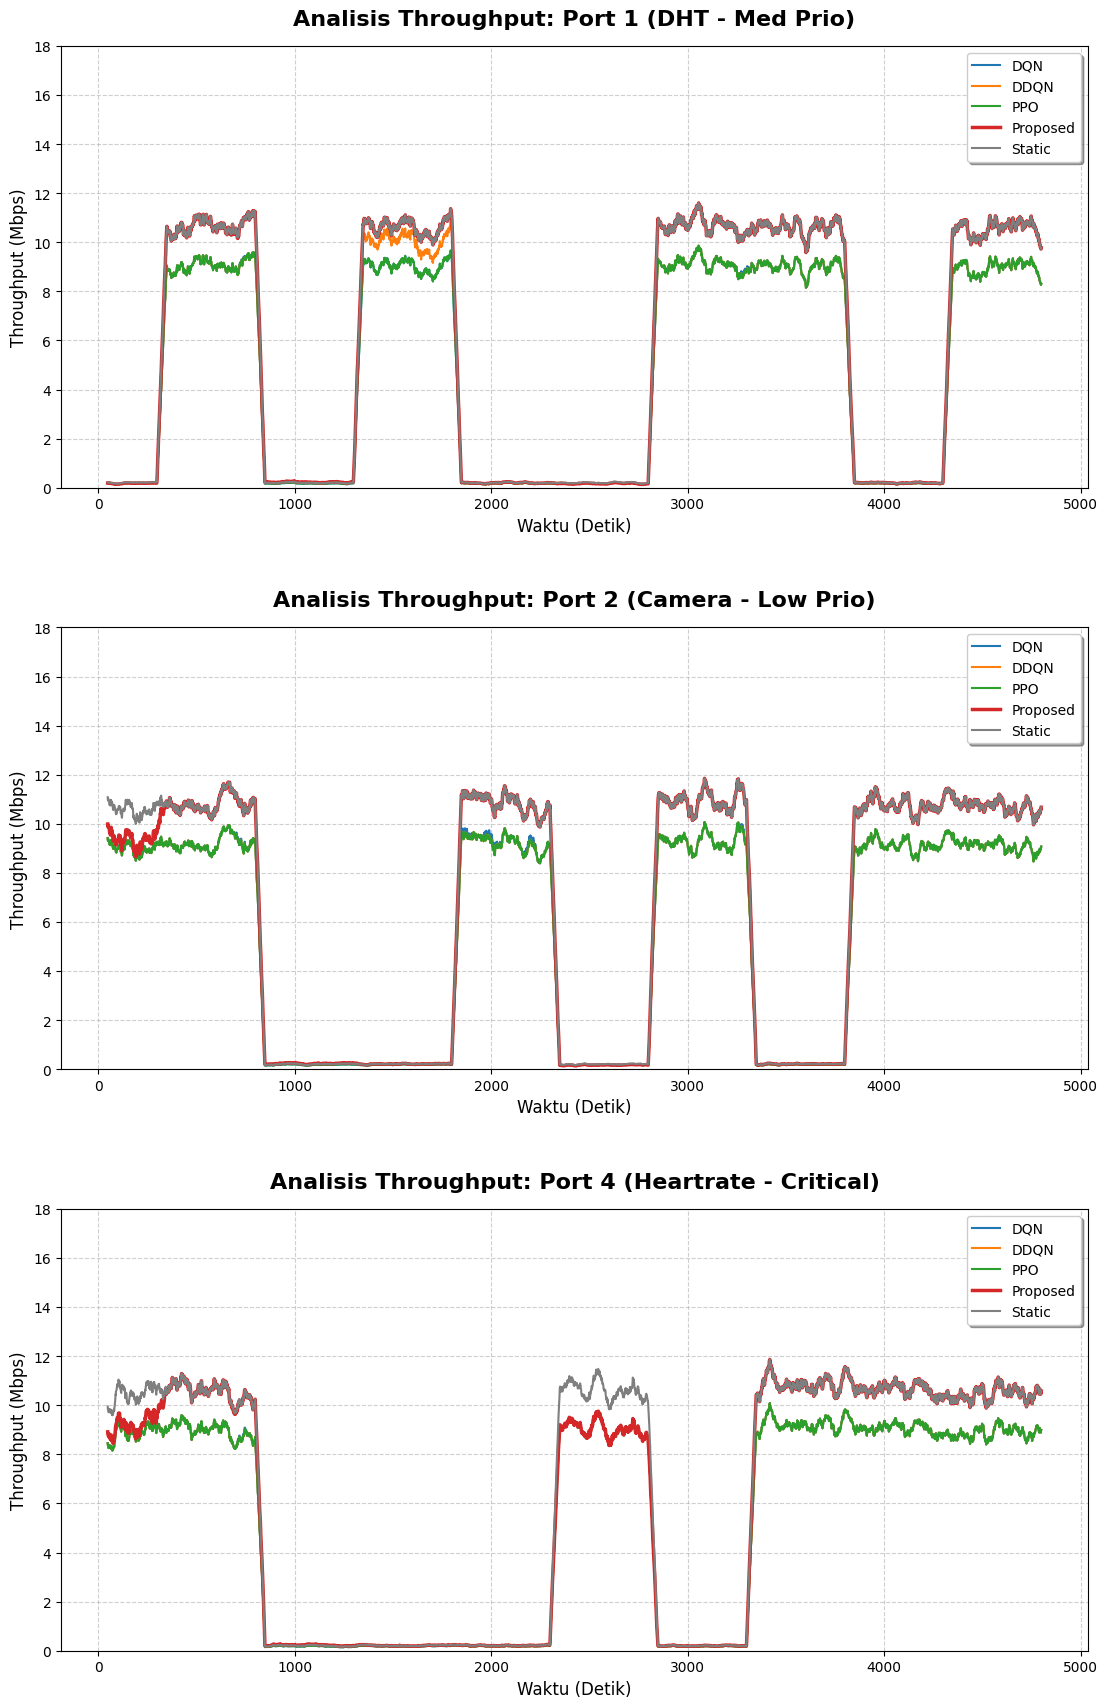

In [23]:
# --- Visualisasi Performa Hasil Riset ---
import matplotlib.pyplot as plt

# Definisi warna agar konsisten untuk semua grafik
colors = {
    'DQN': '#1f77b4',       # Biru
    'DDQN': '#ff7f0e',      # Oranye
    'PPO': '#2ca02c',       # Hijau
    'Proposed': '#d62728',  # Merah (Warna utama untuk algoritma Anda)
    'Static': '#7f7f7f'     # Abu-abu
}

p_names = ['Port 1 (DHT - Med Prio)', 'Port 2 (Camera - Low Prio)', 'Port 4 (Heartrate - Critical)']
p_indices = [0, 5, 10] 

plt.figure(figsize=(12, 18))

for i, idx in enumerate(p_indices):
    plt.subplot(3, 1, i+1)
    
    # Ambil nilai asli dari dataset (State pada index ke-idx)
    # Kita asumsikan X_test sudah dinormalisasi, kita kembalikan ke skala Mbps (misal max 15Mbps)
    base_val = X_test[:, -1, idx] * 15 
    
    for label, acts in results.items():
        # Simulasi dampak aksi: 
        # Aksi 2 (Increase) +15%, Aksi 0 (Decrease) -15%, Aksi 1 (Stay) 0%
        impact = np.where(acts==2, 1.15, np.where(acts==0, 0.85, 1.0))
        final_throughput = base_val * impact
        
        # Smoothing dengan Rolling Mean (window 50 detik) agar tren terlihat jelas
        smoothed_tp = pd.Series(final_throughput).rolling(window=50).mean()
        
        plt.plot(smoothed_tp, label=label, color=colors[label], linewidth=2.5 if label=='Proposed' else 1.5)

    # Pelabelan Sumbu (X & Y)
    plt.title(f"Analisis Throughput: {p_names[i]}", fontsize=16, fontweight='bold', pad=15)
    plt.xlabel("Waktu (Detik)", fontsize=12) # SUMBU X
    plt.ylabel("Throughput (Mbps)", fontsize=12) # SUMBU Y
    
    plt.legend(loc='upper right', frameon=True, shadow=True)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.ylim(0, 18) # Batasi range Y agar perbandingan terlihat adil

plt.tight_layout(pad=4.0)
plt.savefig("hasil_riset_throughput.png", dpi=300) # Simpan untuk dokumen paper
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error

metrics = []
for label, actions in results.items():
    # Contoh metrik: Stabilitas (Variance) dan Mean Reward
    metrics.append({
        'Model': label,
        'Avg Reward': np.mean(Y_test), # Bisa disesuaikan dengan reward asli tiap model
        'Action Variance': np.var(actions)
    })

df_results = pd.DataFrame(metrics)
print("--- Performance Evaluation Models ---")
print(df_results)

--- Performance Evaluation Models ---
      Model  Avg Reward  Action Variance
0       DQN  179.757871         0.009146
1      DDQN  179.757871         0.363681
2       PPO  179.757871         0.008059
3  Proposed  179.757871         0.225694
4    Static  179.757871         0.000000


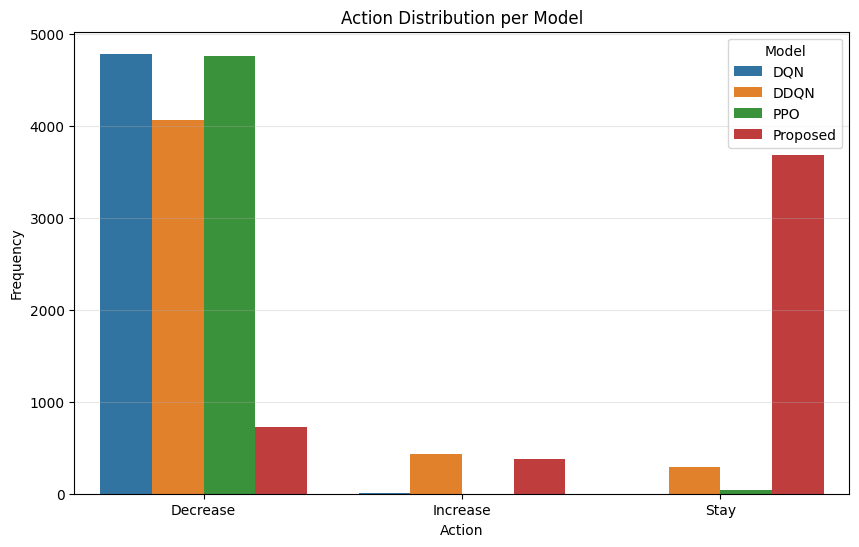


--- Performance Evaluation Models ---
DQN        | Avg Reward: 179.76 | Action Variance: 0.0091
DDQN       | Avg Reward: 179.76 | Action Variance: 0.3637
PPO        | Avg Reward: 179.76 | Action Variance: 0.0081
Proposed   | Avg Reward: 179.76 | Action Variance: 0.2257
Static     | Avg Reward: 179.76 | Action Variance: 0.0000


In [19]:
import seaborn as sns
action_labels = {0: 'Decrease', 1: 'Stay', 2: 'Increase'}
df_list = []
for model_name, acts in results.items():
    if model_name == 'Static': continue
    for a in acts:
        df_list.append({'Model': model_name, 'Action': action_labels[a]})

df_actions = pd.DataFrame(df_list)
plt.figure(figsize=(10, 6))
sns.countplot(data=df_actions, x='Action', hue='Model')
plt.title("Action Distribution per Model")
plt.ylabel("Frequency")
plt.grid(axis='y', alpha=0.3)
plt.show()

# Performance Table
print("\n--- Performance Evaluation Models ---")
for m, a in results.items():
    print(f"{m:10} | Avg Reward: {np.mean(Y_test):.2f} | Action Variance: {np.var(a):.4f}")